Exercise 8
===
Let's create an autoencoder network that pretrains on MNIST images.

In [2]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def create_next_batch_fn(data, sequence_lengths, targets, batch_size):
    assert len(data) == len(sequence_lengths) and len(data) == len(targets)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(data)
        return data[i:i+batch_size], sequence_lengths[i:i+batch_size], targets[i:i+batch_size]
    return next_batch

In [3]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 80

learning_rate = 0.01
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 250
n_hidden_neurons_layer2 = 150
n_hidden_neurons_layer3 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
    #var_X = tf.Variable(X, "input_variable", validate_shape=False)
    #assign_var_X = var_X.assign(X)
    #noisy_X = var_X + tf.random_normal(tf.shape(var_X), mean=0.1, stddev=0.1)
    noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
    hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    hidden3 = my_dense_layer(hidden2, n_hidden_neurons_layer3)
    outputs = my_dense_layer(hidden3, n_output_neurons, activation=None)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 20
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run([training_op], feed_dict={X: X_batch})
        l = sess.run(reconstruction_loss, feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_autoencoder_model_final.ckpt")

epoch 0
loss: 4.6819
loss: 0.305103
loss: 0.170676
loss: 0.102501
loss: 0.0828767
loss: 0.0738689
loss: 0.069706
loss: 0.063123
loss: 0.0656001
loss: 0.0647116
loss: 0.0632783
loss: 0.0630296
loss: 0.0648482
loss: 0.0624273
loss: 0.0599958
loss: 0.0615804
loss: 0.0594192
loss: 0.0573793
loss: 0.0557244
loss: 0.0543321
loss: 0.0560098
loss: 0.0517437
loss: 0.0501939
loss: 0.0519159
loss: 0.0524045
loss: 0.04883
loss: 0.0450664
loss: 0.0466347
loss: 0.047476
loss: 0.0471641
loss: 0.0433073
loss: 0.0444803
loss: 0.0487051
loss: 0.0448286
loss: 0.0423721
loss: 0.040614
loss: 0.0363093
loss: 0.0385065
loss: 0.0404968
loss: 0.0382582
loss: 0.0409754
loss: 0.0376807
loss: 0.0386906
loss: 0.0387716
loss: 0.0430345
loss: 0.0364452
loss: 0.0411537
loss: 0.0379263
loss: 0.0401867
loss: 0.0374901
loss: 0.0348598
loss: 0.0417369
loss: 0.0359762
loss: 0.0335021
loss: 0.0337668
loss: 0.0453502
loss: 0.0402652
loss: 0.0391126
loss: 0.0339208
loss: 0.0335017
loss: 0.0329763
loss: 0.0339038
loss: 0.0341

loss: 0.0918094
loss: 0.0649466
loss: 0.0698685
loss: 0.283528
loss: 0.0851951
loss: 0.159659
loss: 0.372585
loss: 0.366856
loss: 0.402421
loss: 0.117929
loss: 0.0702787
loss: 0.39534
loss: 1.62204
loss: 0.310014
loss: 0.1315
loss: 0.511541
loss: 0.132689
loss: 0.102217
loss: 0.237124
loss: 0.843783
loss: 0.348027
loss: 0.133561
loss: 0.116864
epoch 8
loss: 0.0784528
loss: 0.57341
loss: 1.46383
loss: 0.0900332
loss: 0.0710973
loss: 0.0722203
loss: 0.279102
loss: 0.827539
loss: 0.130147
loss: 0.432944
loss: 0.278939
loss: 0.273722
loss: 0.0725586
loss: 0.362495
loss: 0.920726
loss: 0.208507
loss: 0.87739
loss: 0.0699298
loss: 0.0938231
loss: 0.154389
loss: 0.130084
loss: 0.151437
loss: 1.10397
loss: 0.655244
loss: 0.547161
loss: 0.089649
loss: 0.0706455
loss: 0.151498
loss: 0.0788663
loss: 0.0707833
loss: 0.17208
loss: 0.0747327
loss: 0.196288
loss: 0.137475
loss: 0.127204
Stopping early during epoch 8 with best loss: 0.0138294
INFO:tensorflow:Restoring parameters from ./checkpoints/mni

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)

Visualise the low-level featues.

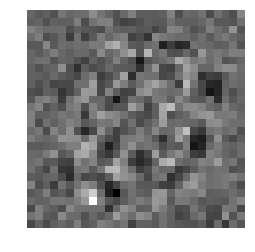

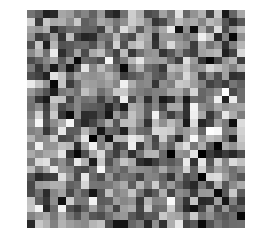

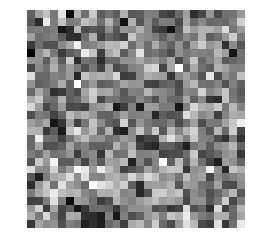

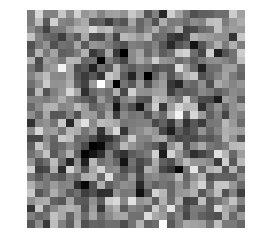

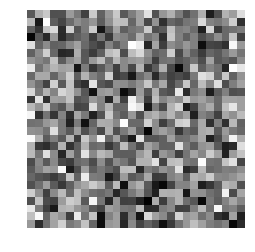

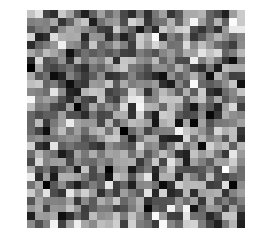

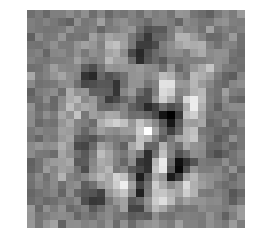

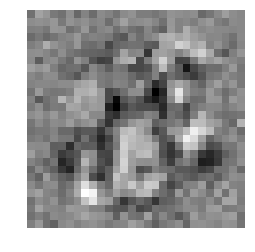

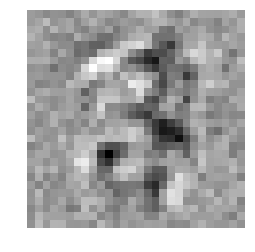

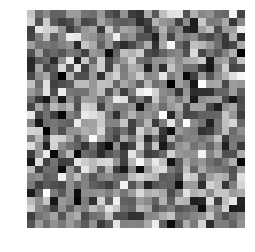

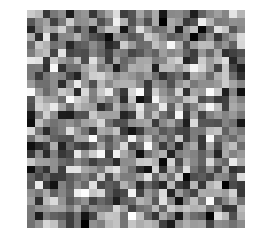

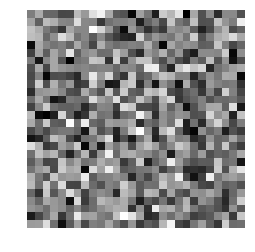

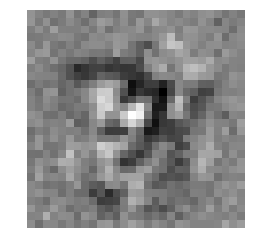

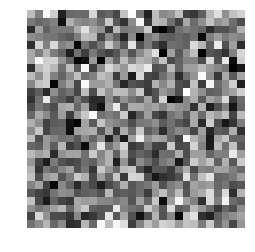

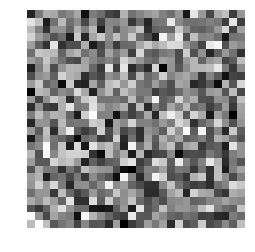

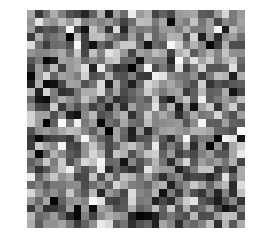

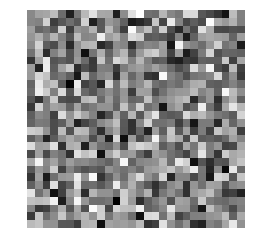

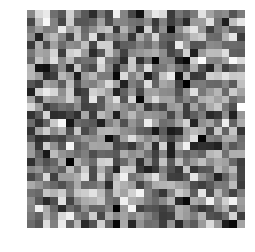

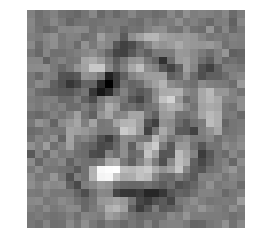

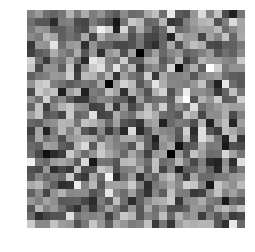

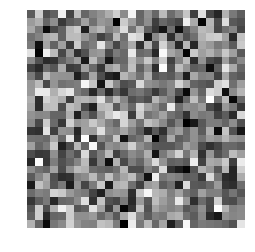

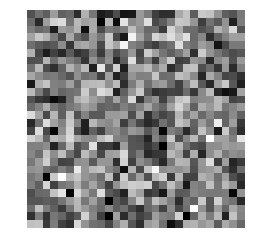

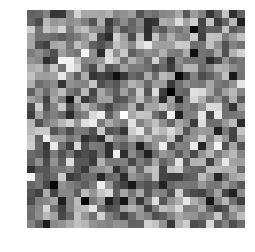

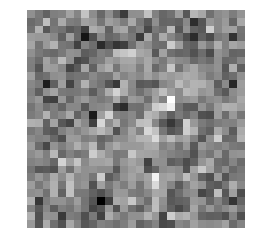

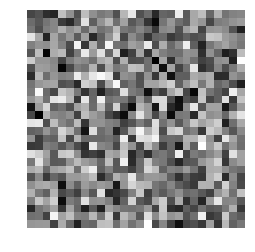

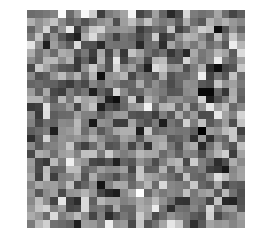

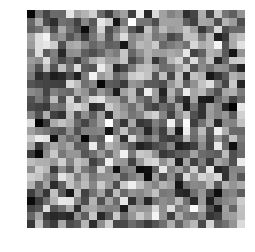

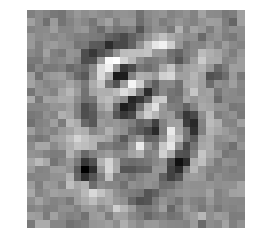

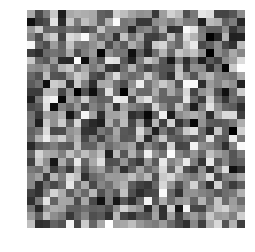

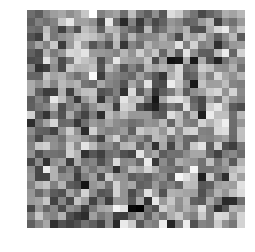

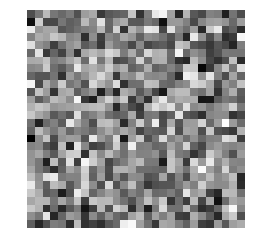

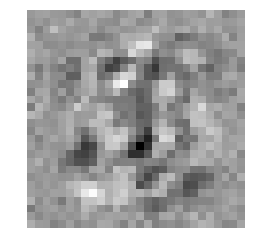

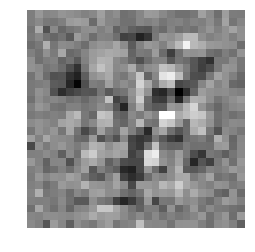

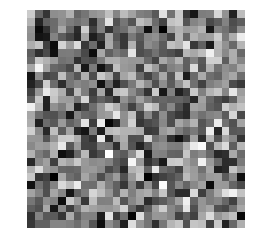

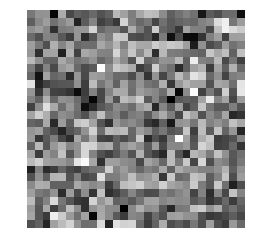

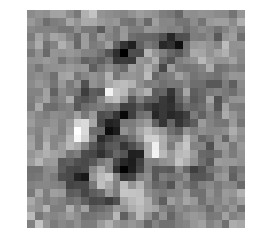

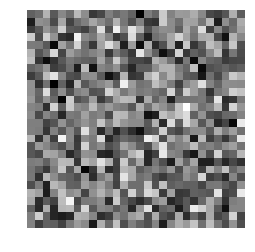

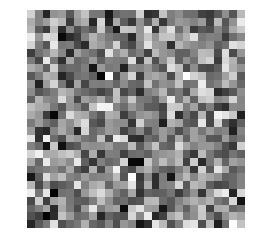

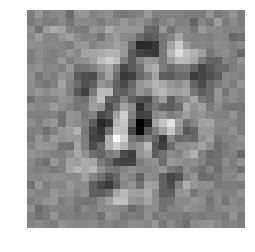

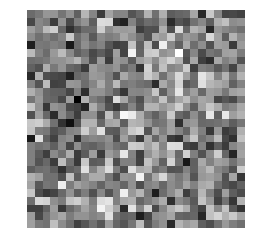

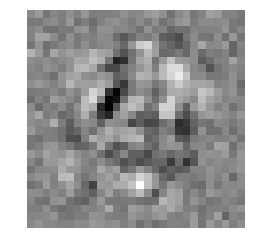

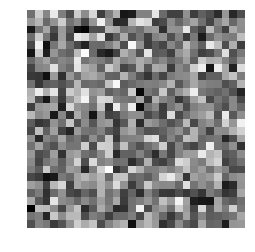

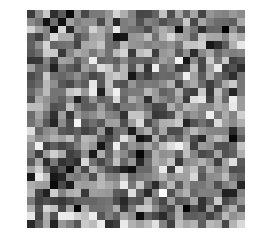

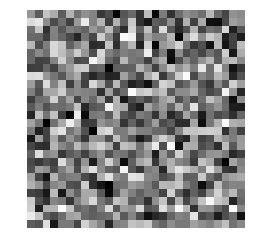

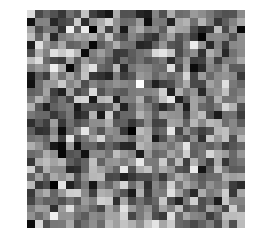

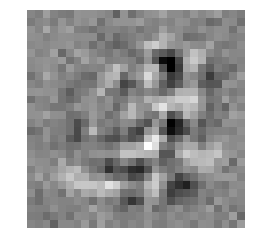

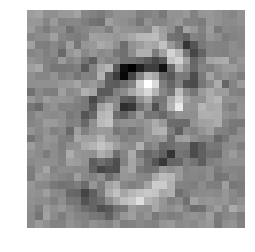

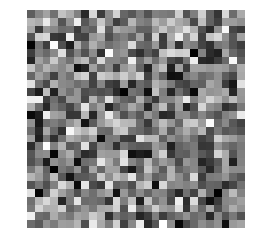

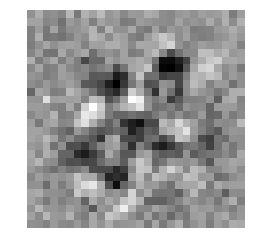

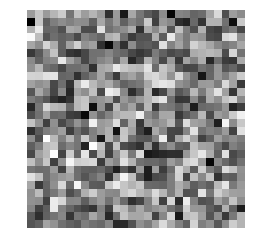

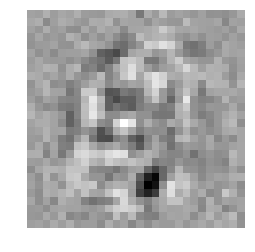

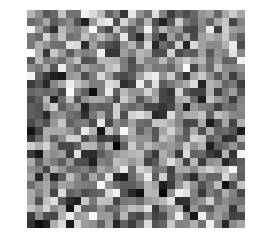

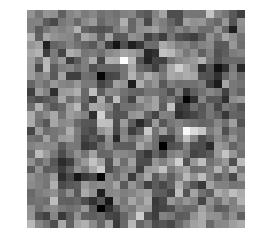

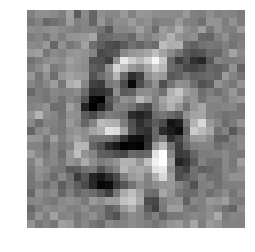

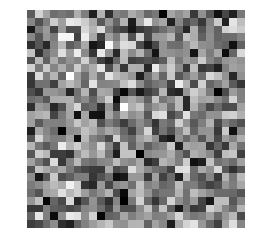

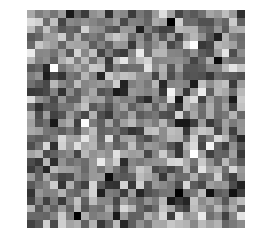

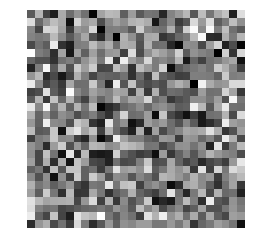

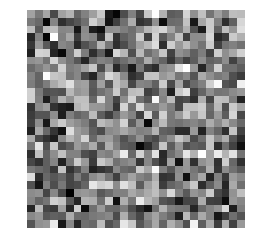

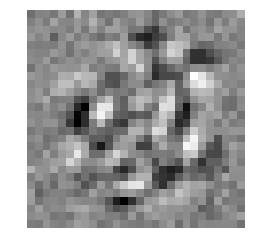

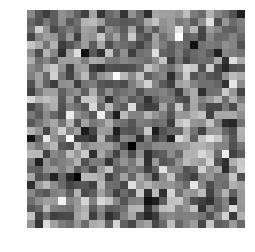

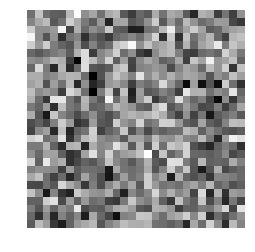

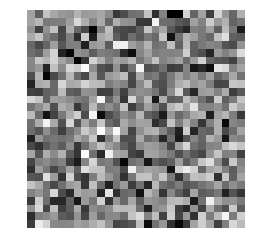

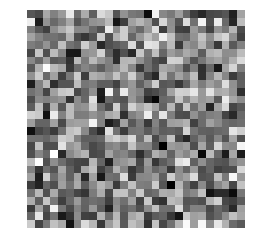

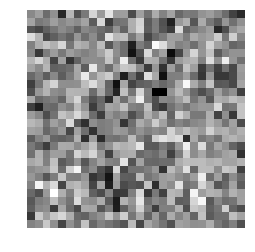

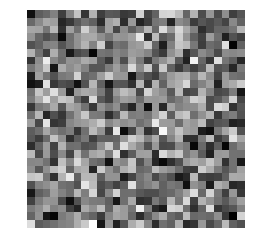

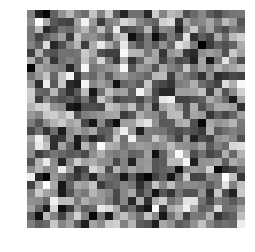

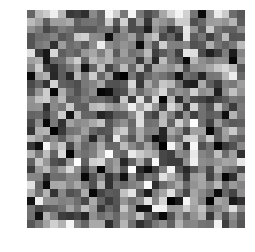

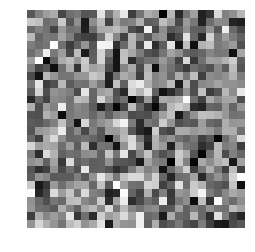

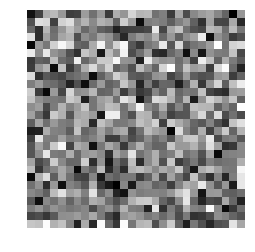

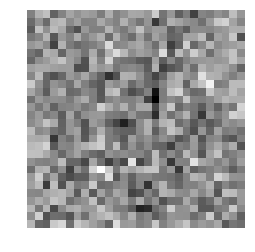

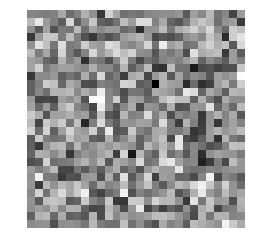

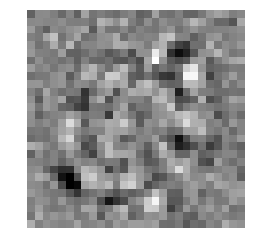

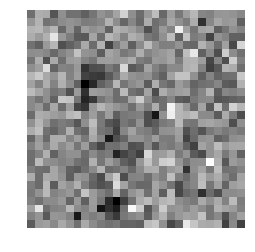

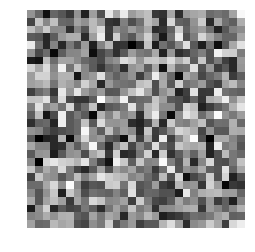

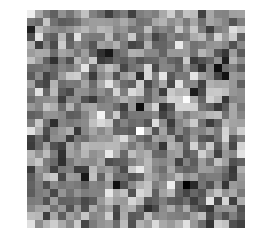

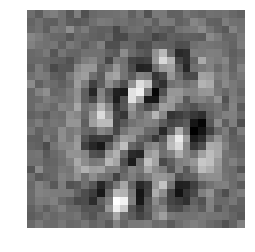

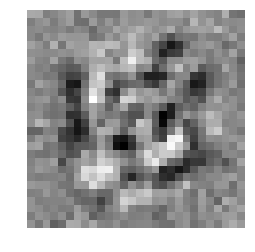

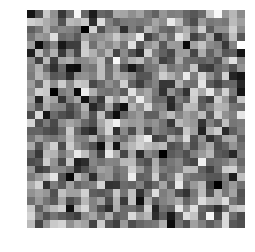

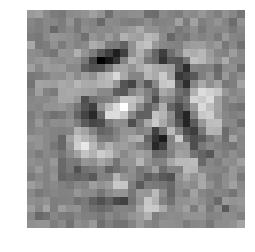

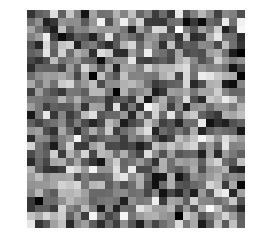

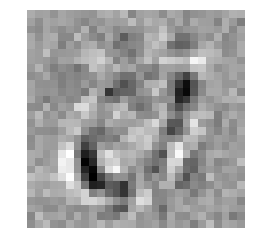

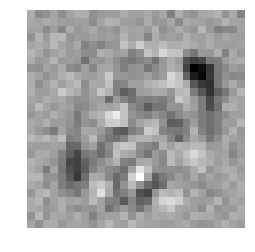

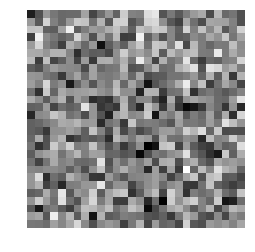

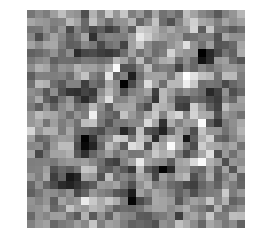

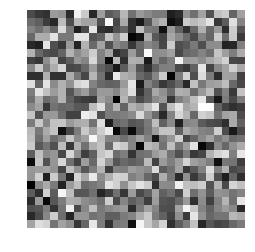

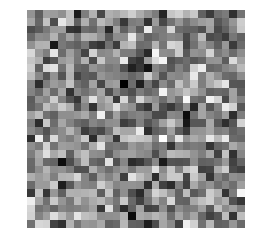

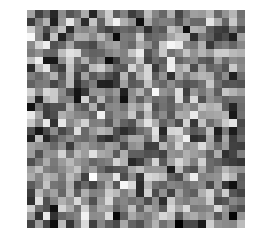

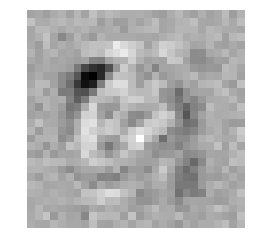

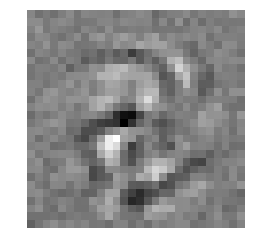

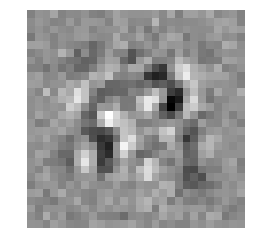

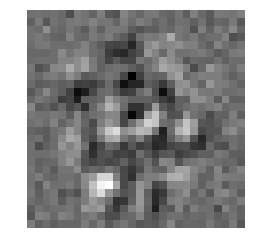

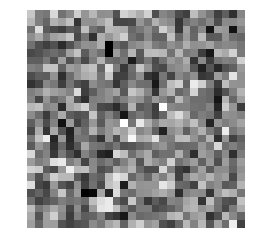

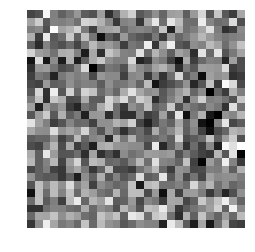

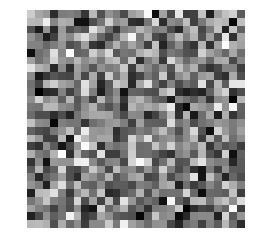

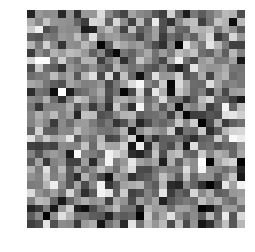

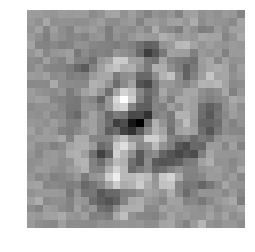

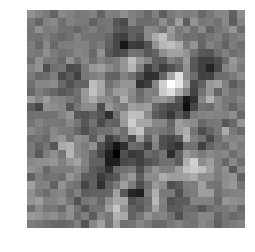

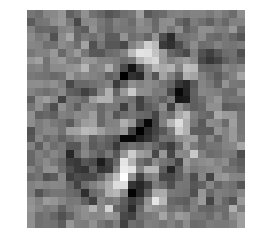

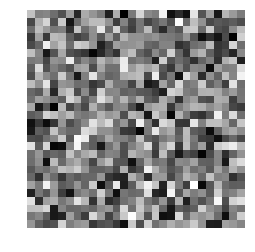

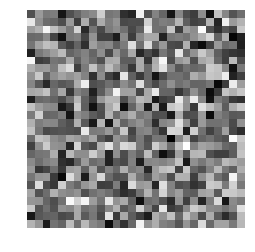

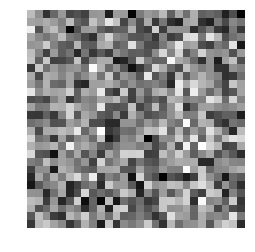

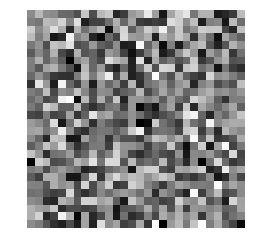

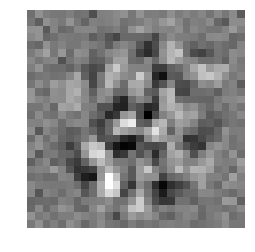

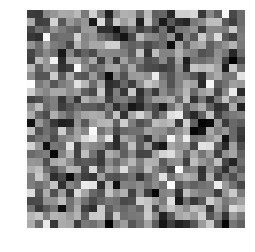

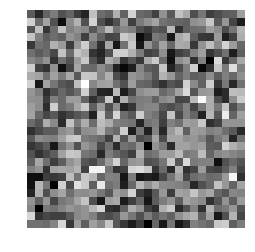

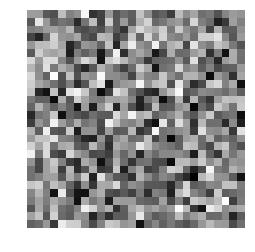

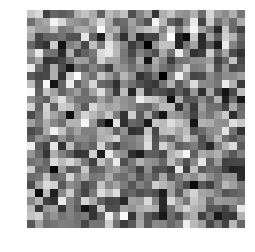

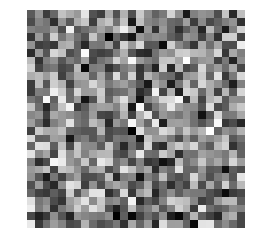

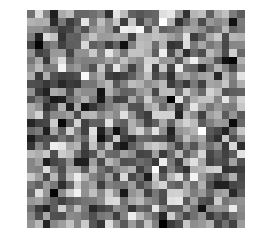

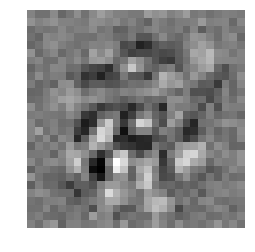

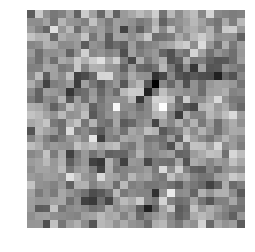

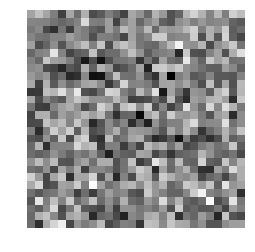

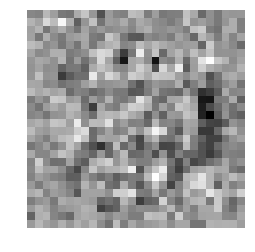

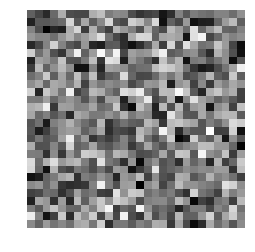

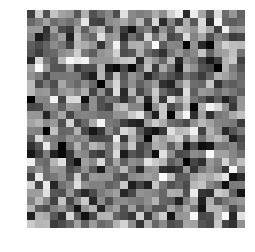

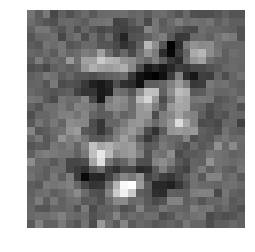

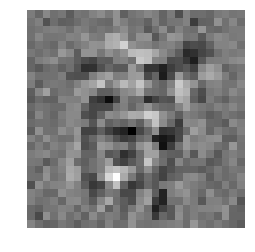

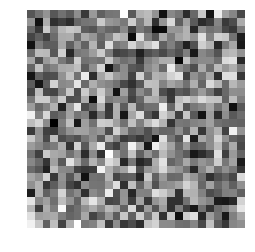

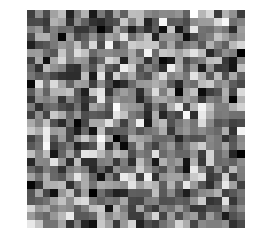

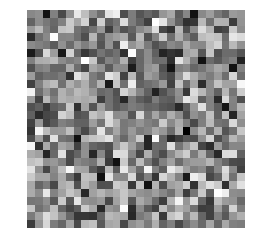

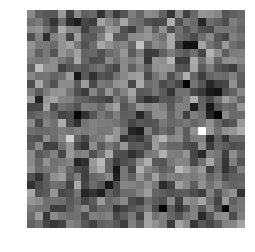

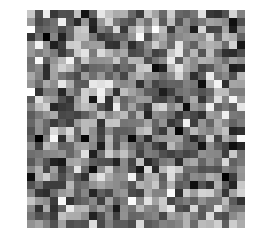

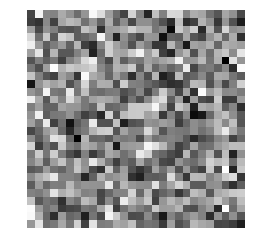

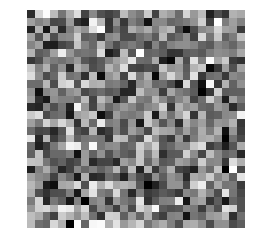

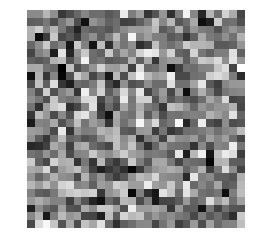

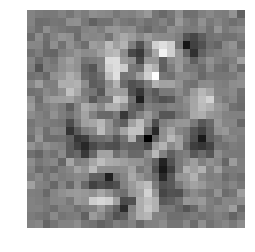

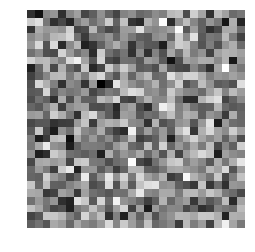

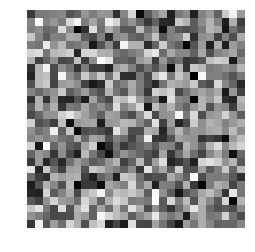

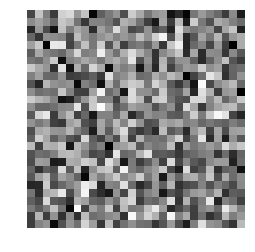

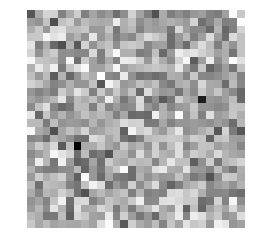

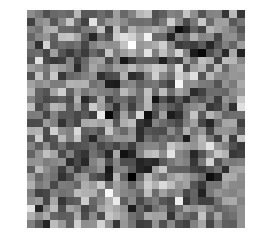

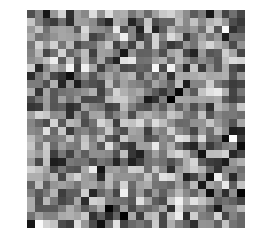

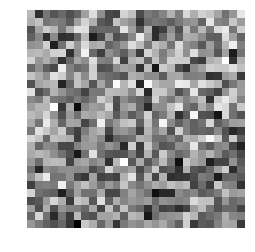

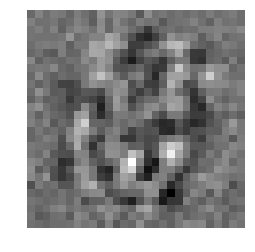

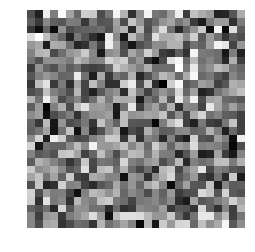

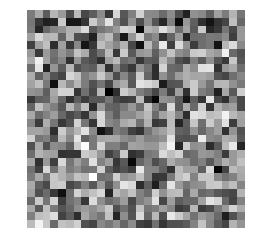

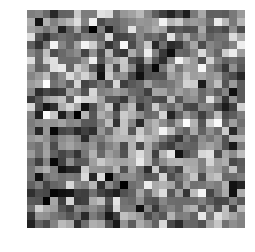

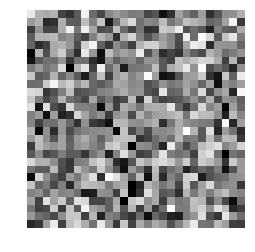

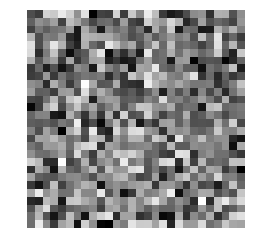

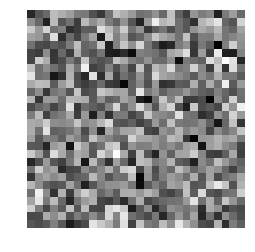

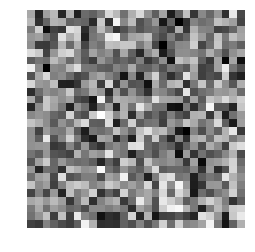

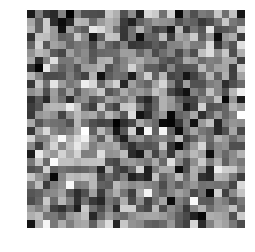

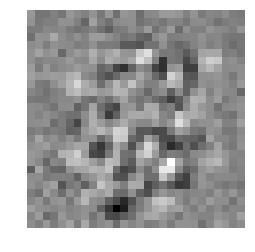

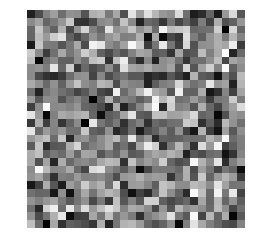

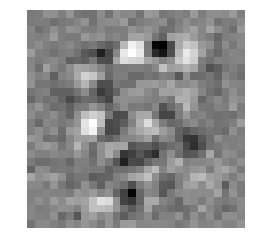

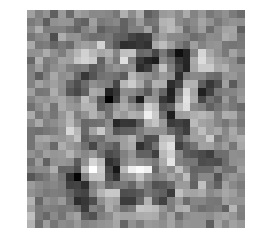

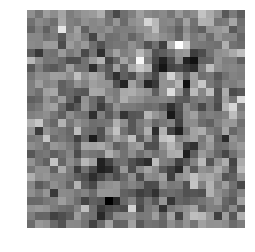

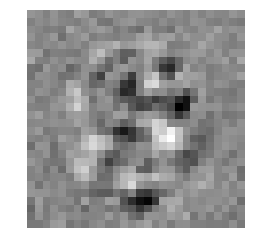

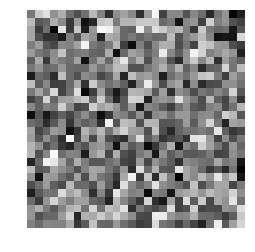

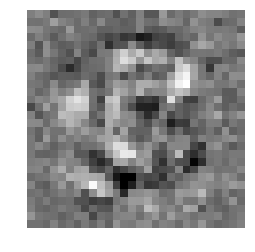

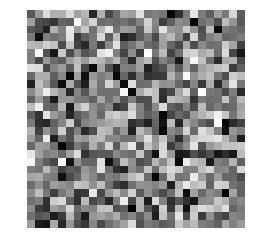

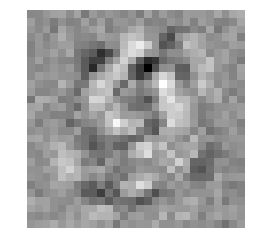

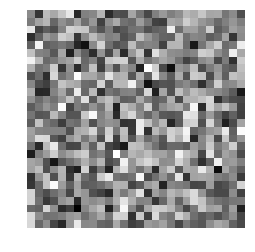

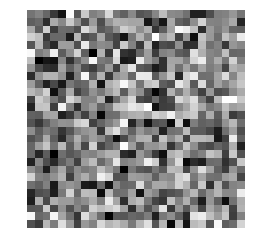

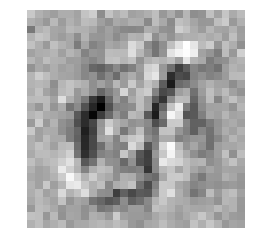

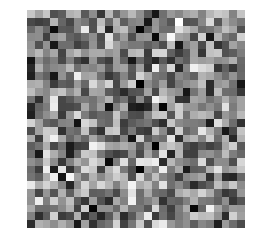

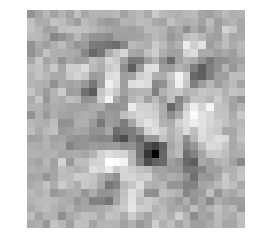

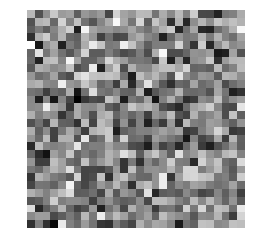

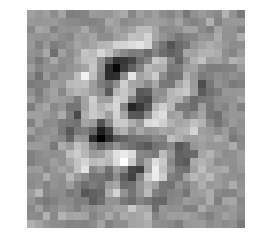

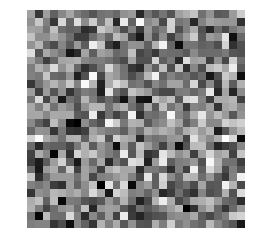

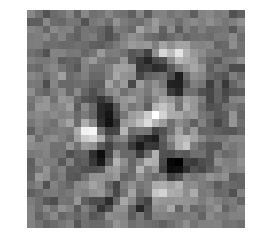

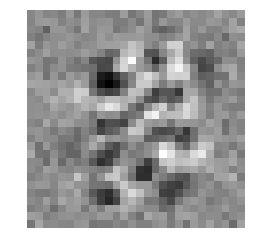

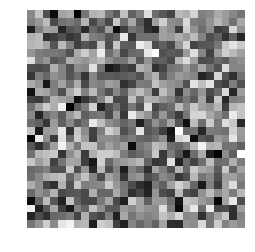

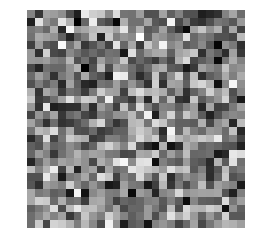

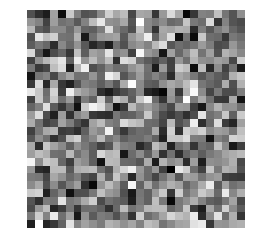

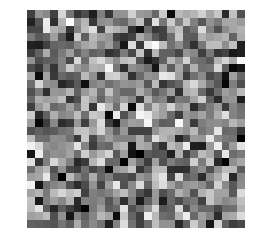

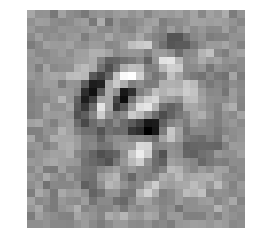

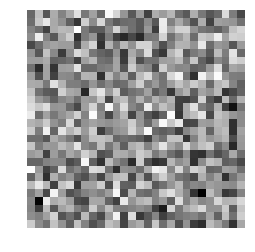

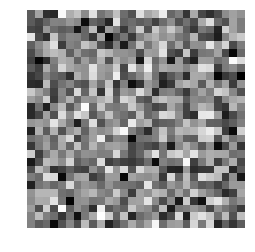

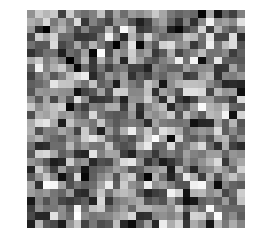

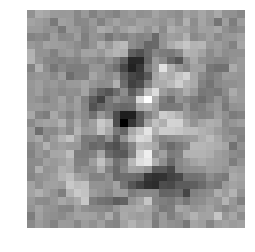

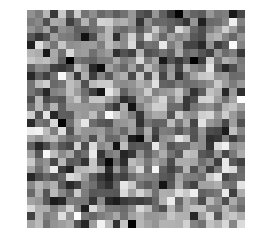

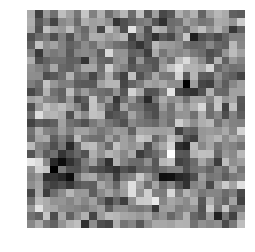

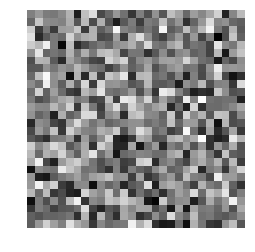

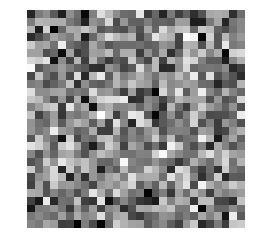

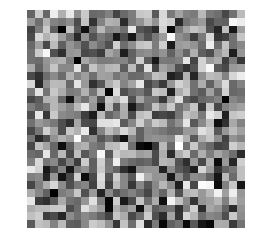

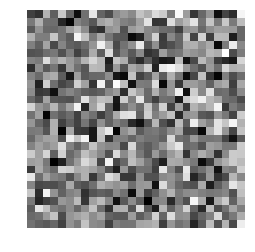

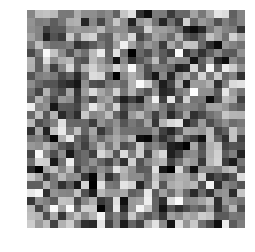

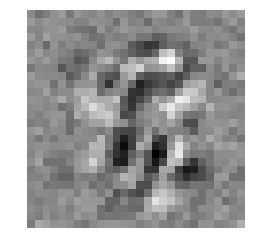

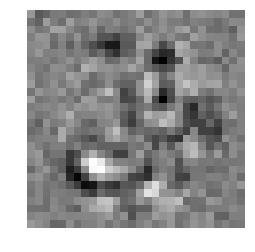

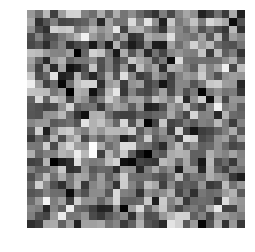

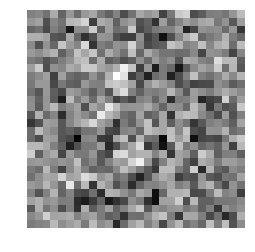

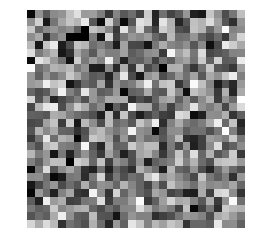

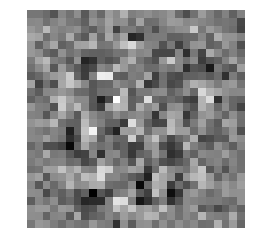

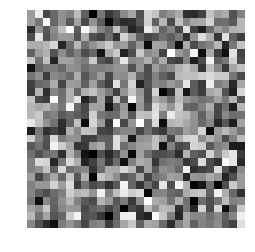

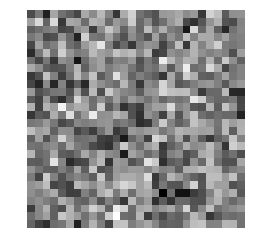

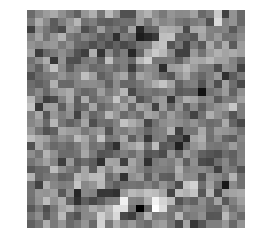

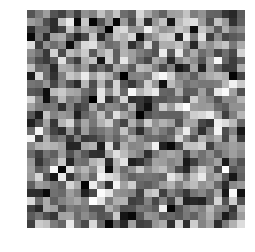

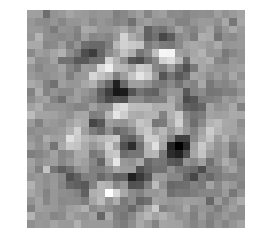

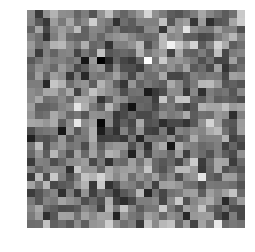

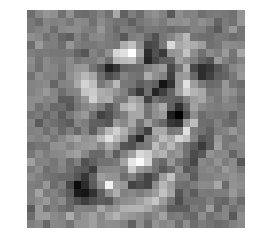

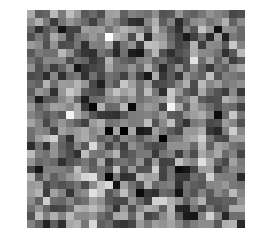

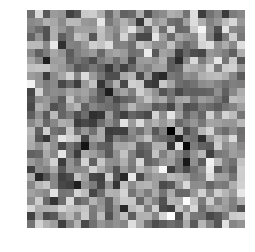

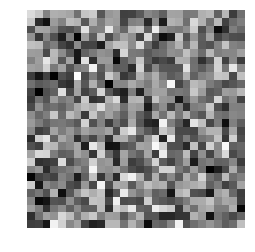

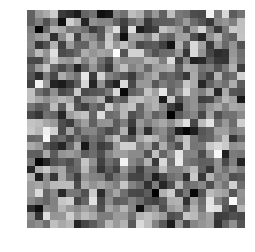

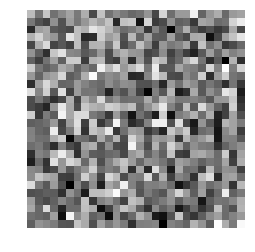

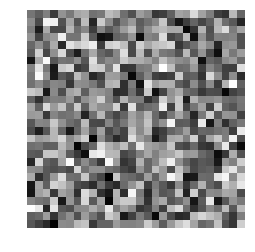

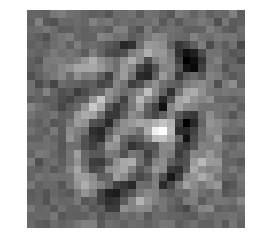

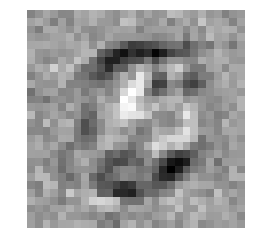

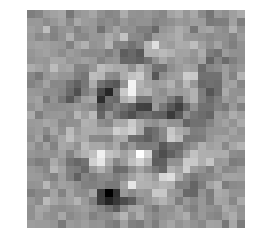

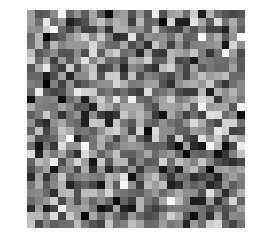

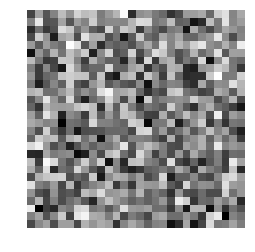

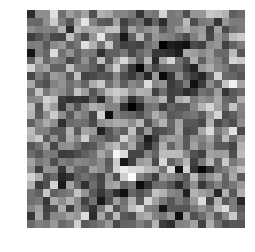

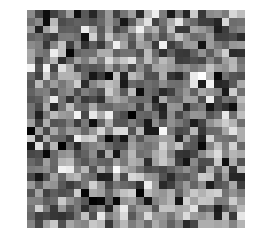

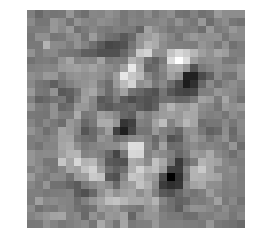

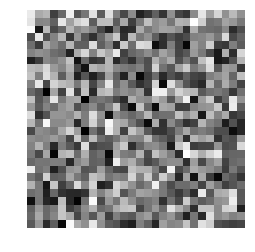

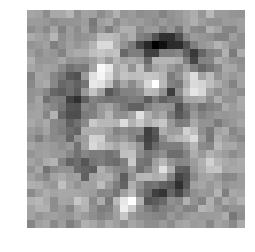

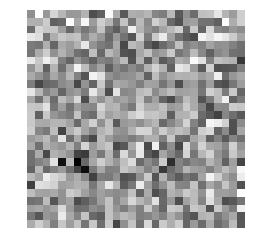

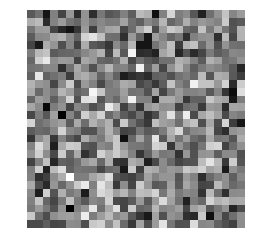

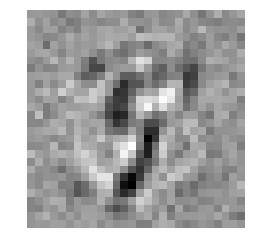

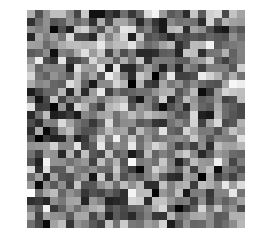

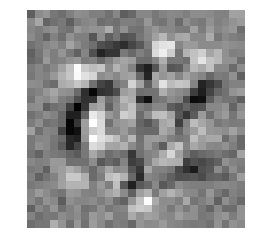

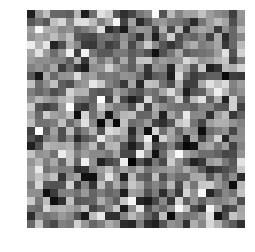

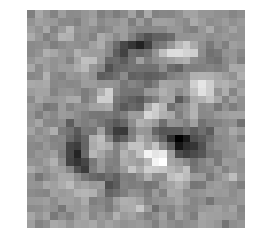

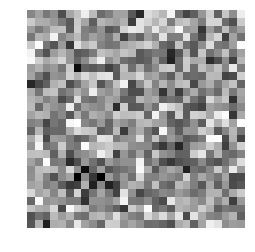

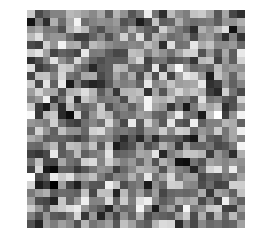

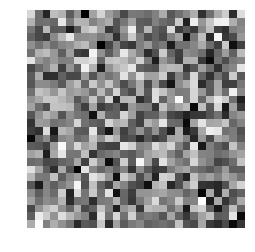

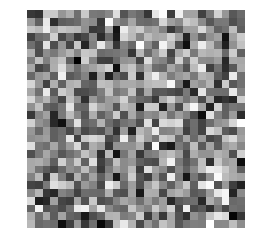

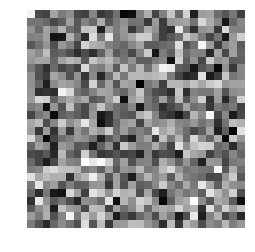

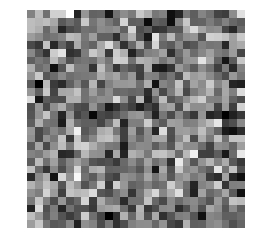

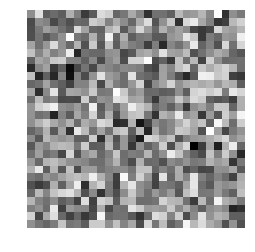

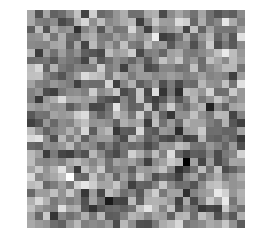

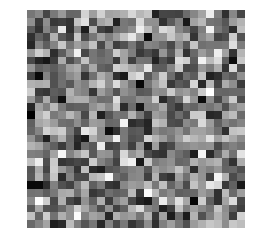

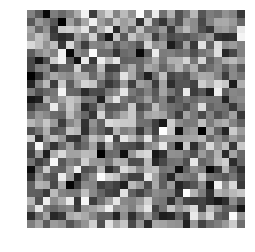

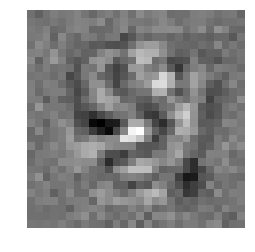

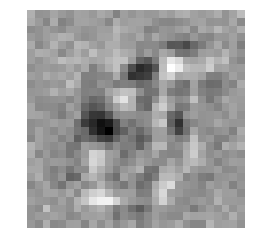

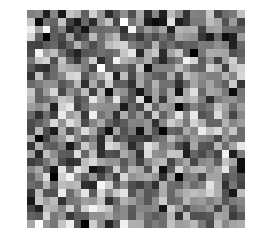

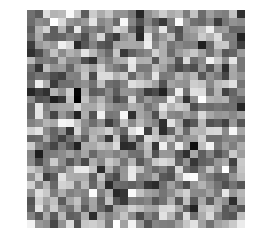

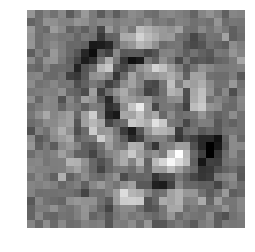

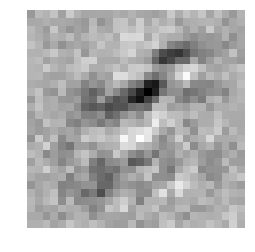

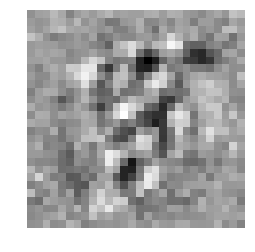

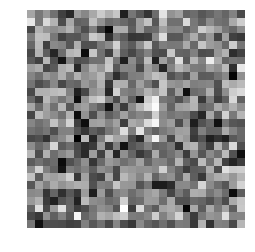

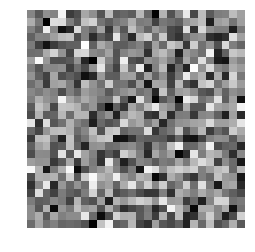

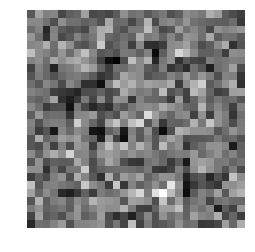

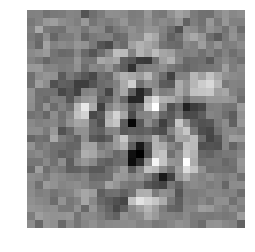

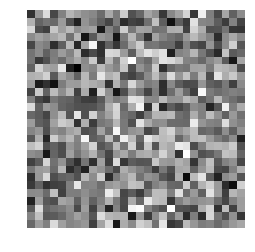

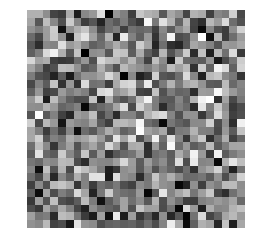

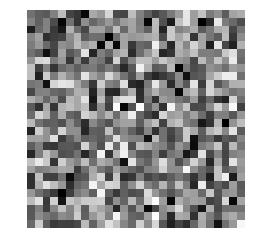

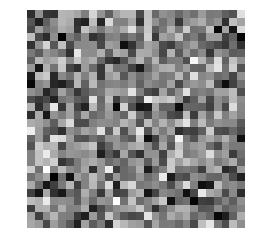

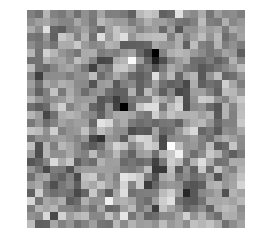

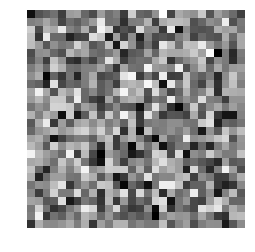

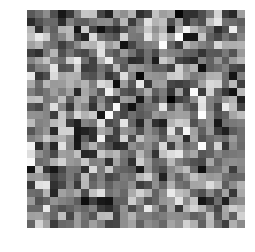

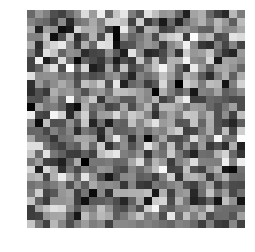

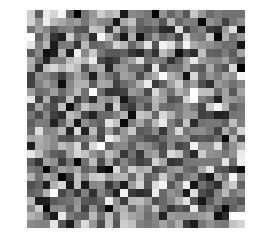

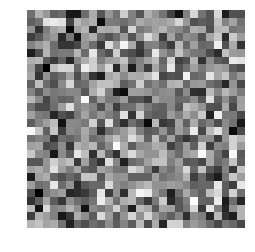

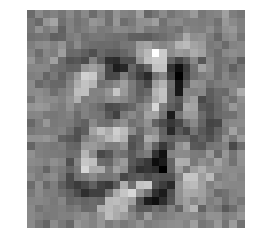

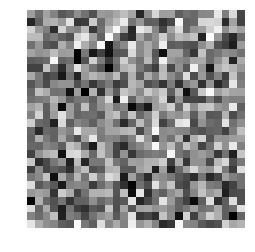

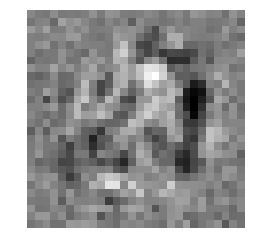

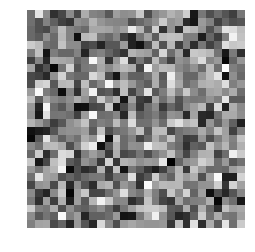

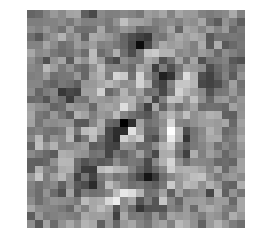

In [16]:
import os

def get_layer_weights(layer):
    # Attribution: https://stackoverflow.com/a/45372632/137996
    return tf.get_default_graph().get_tensor_by_name(os.path.split(layer.name)[0] + '/kernel:0')

with sess.as_default():
    # Go through each low lever neuron and turn its weights into an image.
    hidden1_weights = get_layer_weights(hidden1)
    for neuron_weights in np.transpose(hidden1_weights.eval()):
        show_image(neuron_weights.reshape(image_shape))

Interestingly, it appears that some neurons have random weights, which may be doing nothing. When other neurons are looking for specific shapes or even numbers like the number 3.

Visualise the images that activate each neuron the most in the coding layer.

**The follow code block doesn't work.**

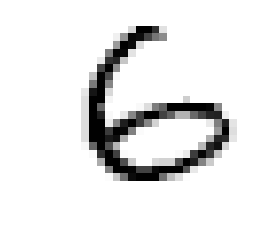

NotImplementedError: ('Trying to optimize unsupported type ', <tf.Tensor 'input:0' shape=(?, 784) dtype=float32>)

In [38]:
import random

with sess.as_default():
    for i in range(n_hidden_neurons_layer2):
        if i == 1: break
        rnd_image = mnist.train.images[random.randint(0, len(mnist.train.images))]
        show_image(rnd_image.reshape(image_shape))
        neuron_output = hidden2[:, i]
        altered_image = rnd_image.reshape((1, input_spatial_size ** 2))
        with tf.name_scope("visualisation_training"):
            visualisation_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            visualisation_training_op = optimizer.minimize(tf.pow(neuron_output, -1), var_list=[X])
            for j in range(10):
                _, altered_image = sess.run([visualisation_training_op, X], feed_dict={X: X_batch})
            show_image(altered_image.reshape(image_shape))

Build a classification deep neural network, reuse the lower layers of the autoencoder.

In [9]:
clf_n_hidden_neurons_layer3 = 200

with tf.device("/gpu:0"):
    y = tf.placeholder(tf.int32, shape=(None), name="labels")
    
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    clf_hidden3 = my_dense_layer(hidden2, clf_n_hidden_neurons_layer3)
    logits = my_dense_layer(clf_hidden3, n_output_neurons)

    with tf.name_scope("loss"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        clf_loss = tf.reduce_mean(cross_entropy, name="loss")

    with tf.name_scope("training"):
        clf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        clf_training_op = optimizer.minimize(clf_loss)

with tf.name_scope("eval"):
    k = 1
    correctness = tf.nn.in_top_k(logits, y, k)
    accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32)) * 100.0
    
clf_init = tf.global_variables_initializer()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

epochs = 6
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

saver = tf.train.Saver()
early_stopping_checkpoint_path = "./checkpoints/mnist_model_early_stopping.ckpt"

sess.run(clf_init)

def create_next_batch_fn(images, labels, batch_size):
    assert len(images) == len(labels)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(images)
        return images[i:i+batch_size], labels[i:i+batch_size]
    return next_batch

training_size = int(len(mnist.train.images) / 10)
print("training dataset size", training_size)
create_next_batch = create_next_batch_fn(
    mnist.train.images[:training_size],
    mnist.train.labels[:training_size],
    batch_size)


best_validation_acc = 0.0
best_validation_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        X_batch, y_batch = create_next_batch()
        t, l, ta = sess.run([clf_training_op, clf_loss, accuracy], feed_dict={X: X_batch, y: y_batch})
        #l = sess.run(clf_loss, feed_dict={X: X_batch, y: y_batch})
        if batch_index % 10 == 0:
            print("loss:", l, "training accuracy:", ta)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            validation_acc = sess.run(accuracy, feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print("validation accuracy", validation_acc)
            if validation_acc > best_validation_acc:
                saver.save(sess, early_stopping_checkpoint_path)
                best_validation_acc = validation_acc
                best_validation_step = step
            elif step >= (best_validation_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch)
                break
    else:
        continue
    break
saver.restore(sess, early_stopping_checkpoint_path)
test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})
print(">>>>>>>>>> test dataset accuracy:", test_acc)

training dataset size 5500
epoch 0
loss: 7.16401 training accuracy: 0.0
validation accuracy 18.24
loss: 5.44564 training accuracy: 5.0
loss: 4.9133 training accuracy: 30.0
loss: 4.66376 training accuracy: 25.0
loss: 4.30403 training accuracy: 31.25
loss: 4.0594 training accuracy: 35.0
loss: 3.02549 training accuracy: 52.5
loss: 2.71482 training accuracy: 48.75
loss: 1.86339 training accuracy: 62.5
loss: 1.14975 training accuracy: 72.5
loss: 0.566938 training accuracy: 78.75
loss: 0.385548 training accuracy: 86.25
loss: 0.632999 training accuracy: 81.25
loss: 0.449718 training accuracy: 83.75
loss: 0.352054 training accuracy: 87.5
loss: 0.332834 training accuracy: 90.0
loss: 0.251676 training accuracy: 93.75
loss: 0.329066 training accuracy: 87.5
validation accuracy 87.24
loss: 0.315975 training accuracy: 91.25
loss: 0.321152 training accuracy: 92.5
loss: 0.209813 training accuracy: 91.25
loss: 0.548282 training accuracy: 86.25
loss: 0.433427 training accuracy: 86.25
loss: 0.578087 trai

loss: 0.0807218 training accuracy: 97.5
loss: 0.144689 training accuracy: 93.75
loss: 0.0476291 training accuracy: 98.75
loss: 0.0990969 training accuracy: 97.5
loss: 0.156743 training accuracy: 96.25
loss: 0.283174 training accuracy: 97.5
loss: 0.27081 training accuracy: 91.25
loss: 0.119824 training accuracy: 96.25
loss: 0.0303533 training accuracy: 98.75
validation accuracy 93.64
epoch 3
loss: 0.117808 training accuracy: 96.25
validation accuracy 92.56
loss: 0.129269 training accuracy: 95.0
loss: 0.0137236 training accuracy: 100.0
loss: 0.207943 training accuracy: 95.0
loss: 0.0598483 training accuracy: 97.5
loss: 0.322282 training accuracy: 92.5
loss: 0.0666062 training accuracy: 97.5
loss: 0.000717359 training accuracy: 100.0
loss: 0.0608912 training accuracy: 97.5
loss: 0.0251171 training accuracy: 98.75
loss: 0.0315935 training accuracy: 98.75
loss: 0.0333706 training accuracy: 98.75
loss: 0.0557113 training accuracy: 97.5
loss: 0.0185976 training accuracy: 98.75
loss: 0.370867 

loss: 0.0556905 training accuracy: 98.75
validation accuracy 94.38
loss: 0.0861675 training accuracy: 98.75
loss: 0.00127035 training accuracy: 100.0
loss: 0.0109982 training accuracy: 100.0
loss: 0.10134 training accuracy: 98.75
loss: 0.0510172 training accuracy: 98.75
loss: 0.101326 training accuracy: 97.5
loss: 0.136724 training accuracy: 96.25
loss: 0.0130213 training accuracy: 100.0
loss: 0.421661 training accuracy: 96.25
loss: 0.173443 training accuracy: 97.5
loss: 0.113539 training accuracy: 96.25
loss: 0.0342072 training accuracy: 98.75
loss: 0.00163137 training accuracy: 100.0
loss: 0.117562 training accuracy: 97.5
loss: 1.1923 training accuracy: 88.75
loss: 0.32671 training accuracy: 92.5
loss: 0.553076 training accuracy: 95.0
validation accuracy 90.1
INFO:tensorflow:Restoring parameters from ./checkpoints/mnist_model_early_stopping.ckpt
>>>>>>>>>> test dataset accuracy: 94.27


Creating an ok-performing autoencoder and using transfer learning to create a classifier using 10% of the training data resulted in a test dataset accuracy of test dataset accuracy: 94.27% which is 2.2% less than a model trained from scratch on the entire dataset (with 96.47% test accuracy). This isn't too bad considering that the training dataset is 10% of the size of the comparison model's training setup.

Exercise 9
===

Create a stacked autoencoder:
input -> hidden 1 -> hidden 2 -> coding -> hidden 4 -> hidden 5 -> output

In [10]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 80

learning_rate = 0.1
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 850
n_hidden_neurons_layer2 = 400
n_hidden_neurons_layer3 = 30 # coding layer
n_hidden_neurons_layer4 = n_hidden_neurons_layer2
n_hidden_neurons_layer5 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
    noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
    hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    hidden3 = my_dense_layer(hidden2, n_hidden_neurons_layer3, activation=tf.nn.sigmoid, kernel_initializer=None)
    hidden4 = my_dense_layer(hidden3, n_hidden_neurons_layer4)
    hidden5 = my_dense_layer(hidden4, n_hidden_neurons_layer5)
    outputs = my_dense_layer(hidden5, n_output_neurons, activation=None)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 20
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run([training_op], feed_dict={X: X_batch})
        l = sess.run(reconstruction_loss, feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_semantic_hashing_model_final.ckpt")

epoch 0
loss: 0.402994
loss: 0.121326
loss: 0.128474
loss: 0.138785
loss: 0.132556
loss: 0.131405
loss: 0.131556
loss: 0.134686
loss: 0.134652
loss: 0.132058
loss: 0.136263
loss: 0.129026
loss: 0.129719
loss: 0.13062
loss: 0.129089
loss: 0.133324
loss: 0.132586
loss: 0.138297
loss: 0.139318
loss: 0.136739
loss: 0.137227
loss: 0.135358
loss: 0.135579
loss: 0.131462
loss: 0.127286
loss: 0.129423
loss: 0.136052
loss: 0.135896
loss: 0.135821
loss: 0.130446
loss: 0.133852
loss: 0.135017
loss: 0.130012
loss: 0.131821
loss: 0.13519
loss: 0.137924
loss: 0.132624
loss: 0.133035
loss: 0.132898
loss: 0.134194
loss: 0.130093
loss: 0.133496
loss: 0.134288
loss: 0.134138
loss: 0.13085
loss: 0.132337
loss: 0.14248
loss: 0.127198
loss: 0.131995
loss: 0.136229
loss: 0.133798
loss: 0.136611
loss: 0.129141
loss: 0.132855
loss: 0.13276
loss: 0.129465
loss: 0.129393
loss: 0.132385
loss: 0.134544
loss: 0.133672
loss: 0.13676
loss: 0.133842
loss: 0.133787
loss: 0.135984
loss: 0.135714
loss: 0.131103
loss: 0.

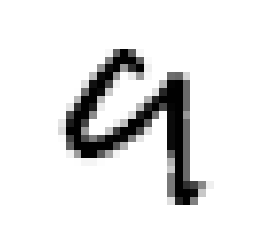

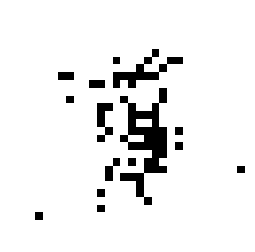

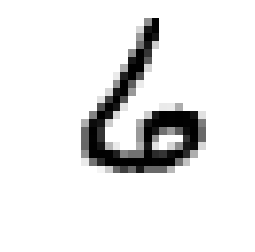

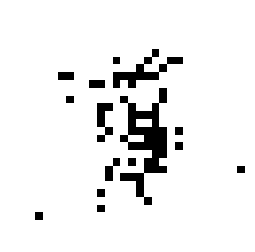

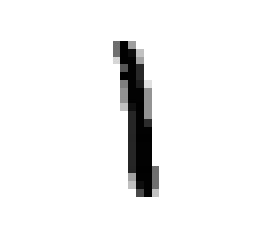

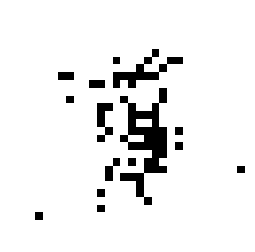

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)

In [9]:
print(mnist.train.images[0])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.